In [1]:
import kagglehub
tharakan684_urecamain_path = kagglehub.dataset_download('tharakan684/urecamain')

print('Data source import complete.')

Data source import complete.


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/urecamain/Train/Fire/firenight722.jpg
/kaggle/input/urecamain/Train/Fire/fireday708.jpg
/kaggle/input/urecamain/Train/Fire/dayroad430.jpg
/kaggle/input/urecamain/Train/Fire/nightroad114.jpg
/kaggle/input/urecamain/Train/Fire/fireday292.jpg
/kaggle/input/urecamain/Train/Fire/SynNig661.jpg
/kaggle/input/urecamain/Train/Fire/SynDay1579.jpg
/kaggle/input/urecamain/Train/Fire/firenight638.jpg
/kaggle/input/urecamain/Train/Fire/firenight363.jpg
/kaggle/input/urecamain/Train/Fire/SynDay1592.jpg
/kaggle/input/urecamain/Train/Fire/dayroad447.jpg
/kaggle/input/urecamain/Train/Fire/dayroad294.jpg
/kaggle/input/urecamain/Train/Fire/fireday490.jpg
/kaggle/input/urecamain/Train/Fire/firenight90.jpg
/kaggle/input/urecamain/Train/Fire/SynDay1447.jpg
/kaggle/input/urecamain/Train/Fire/firenight517.jpg
/kaggle/input/urecamain/Train/Fire/SynNig677.jpg
/kaggle/input/urecamain/Train/Fire/fireday530.jpg
/kaggle/input/urecamain/Train/Fire/SynNi

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set Seed
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
height = 224
width = 224

In [5]:
import os

base_input = "/kaggle/input"
print("Folders in /kaggle/input:\n", os.listdir(base_input))


Folders in /kaggle/input:
 ['urecamain']


In [6]:
test_dir = "/kaggle/input/urecamain/Test/"
valid_dir = "/kaggle/input/urecamain/Vali"
train_dir = "/kaggle/input/urecamain/Train"


def image_gen(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Train dataset
    train_ds = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='binary',
        classes={'Non-Fire': 0., 'Fire': 1.}
    )

    # Validation dataset
    valid_ds = datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=True,
        class_mode='binary',
        classes={'Non-Fire': 0., 'Fire': 1.}
    )

    # Test dataset
    test_ds = datagen.flow_from_directory(
        test_dir,
        target_size= (224, 224),
        class_mode='binary'
    )

    return train_ds, valid_ds, test_ds


def augmented_data(height,width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.5, 1.0)
    )

    train_ds = datagen.flow_from_directory(
        train_dir,
        batch_size=32,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'Non-Fire': 0.,'Fire':1.}
    )

    return train_ds




train_ds, val_ds , test_ds = image_gen(height, width)


print('\n',{"Training Non-Fire cases": len(np.where(train_ds.labels==0)[0]),
             "Training Fire cases": len(np.where(train_ds.labels==1)[0])})


print('\n',{"Validation Non-Fire cases": len(np.where(val_ds.labels==0)[0]),
             "Validation Fire cases": len(np.where(val_ds.labels==1)[0])})


print('\n',{"Test Non-Fire cases": len(np.where(test_ds.labels==0)[0]),
             "Test Fire cases": len(np.where(test_ds.labels==1)[0])})


Found 6003 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

 {'Training Non-Fire cases': 3000, 'Training Fire cases': 3003}

 {'Validation Non-Fire cases': 1000, 'Validation Fire cases': 1000}

 {'Test Non-Fire cases': 1000, 'Test Fire cases': 1000}


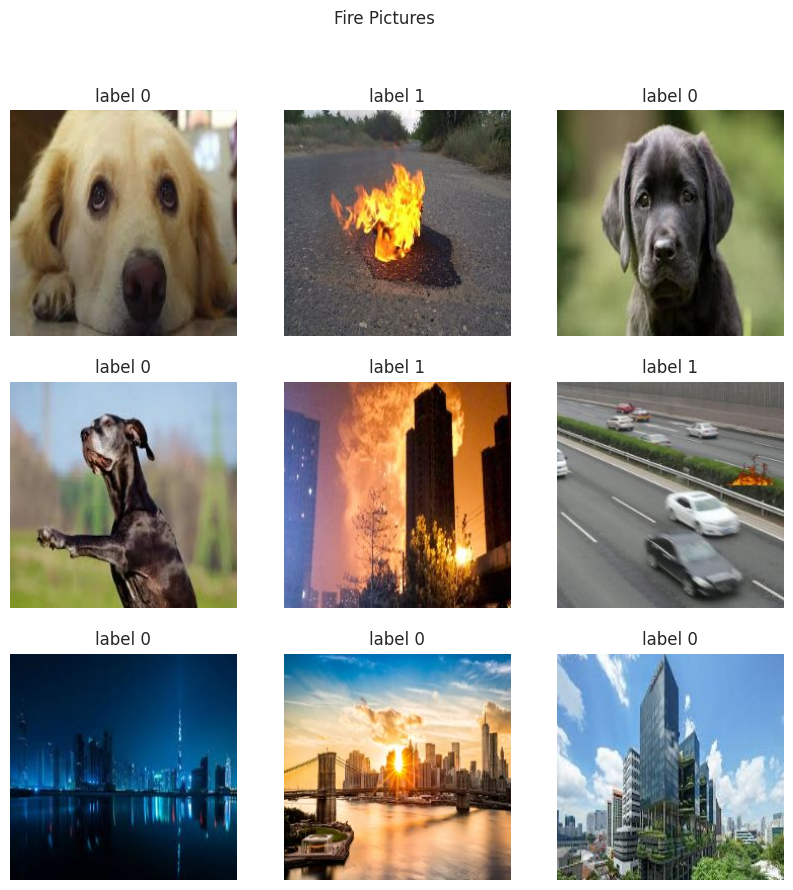

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Fire Pictures")

for k in range(9):
    images, labels = next(train_ds)
    i, j = k // 3, k % 3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()


In [8]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [9]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,858 (91.90 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.keras',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9214 - loss: 0.2007
Epoch 1: accuracy improved from -inf to 0.95086, saving model to model/resnet50v2_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step - accuracy: 0.9216 - loss: 0.2004 - val_accuracy: 0.9300 - val_loss: 0.1964
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9846 - loss: 0.0410
Epoch 2: accuracy improved from 0.95086 to 0.98334, saving model to model/resnet50v2_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9846 - loss: 0.0410 - val_accuracy: 0.9380 - val_loss: 0.1676
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9852 - loss: 0.0354
Epoch 3: accuracy improved from 0.98334 to 0.98734, saving model to model/resnet50v2_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9852 - loss: 0.0353 - val_accuracy: 0.9355 - val_loss: 0.2010
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9955 - loss: 0.0170
Epoch 4

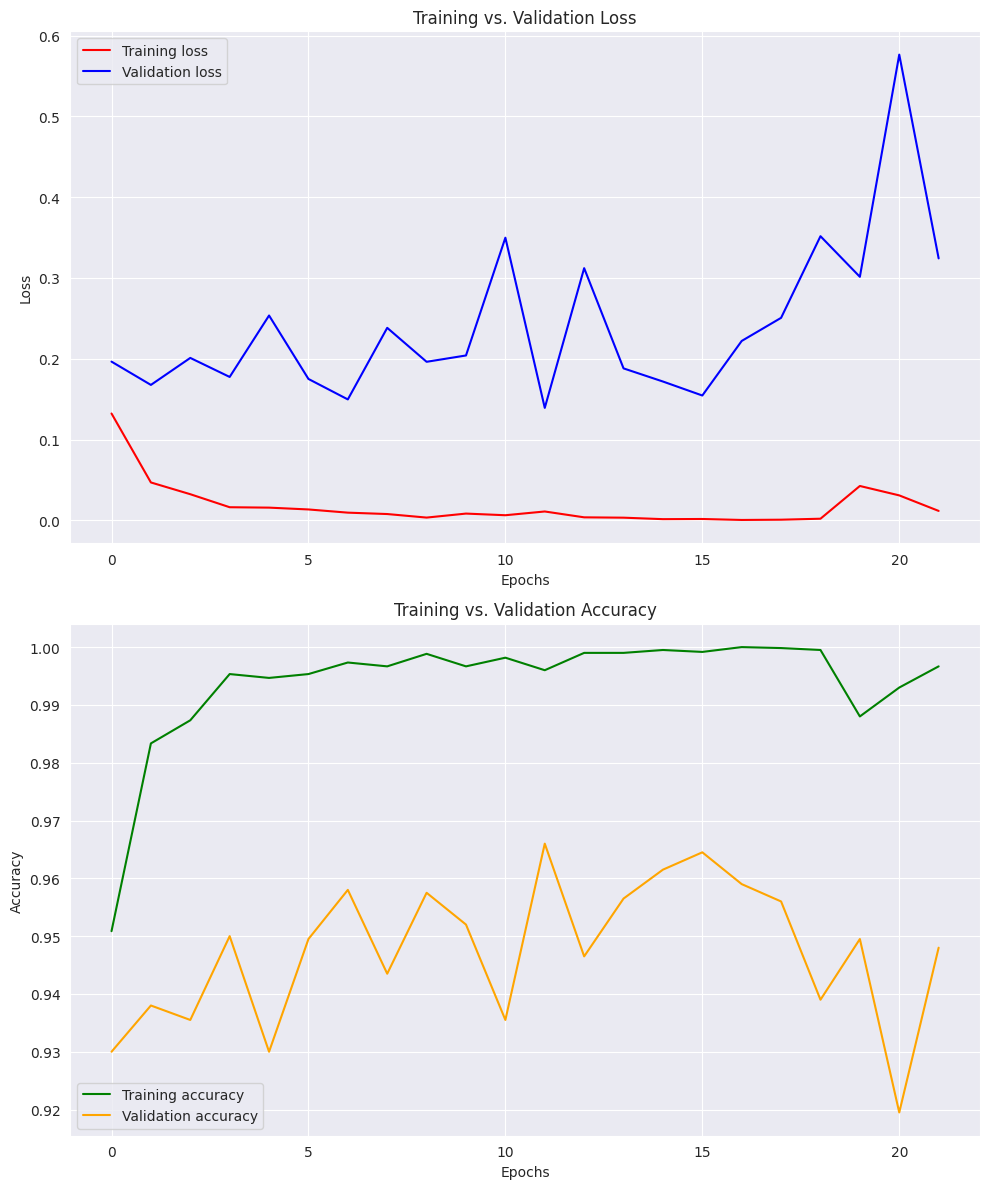

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from history.history
his_data = pd.DataFrame(history.history)

# Create a figure with 2 subplots in a 2x1 grid
plt.figure(figsize=(10,12))

# Plotting training and validation loss in the first subplot
plt.subplot(2, 1, 1)  # (rows, columns, index)
plt.plot(his_data.loss, label="Training loss", color='red')
plt.plot(his_data.val_loss, label="Validation loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.legend(loc='best')

# Plotting training and validation accuracy in the second subplot
plt.subplot(2, 1, 2)
plt.plot(his_data.accuracy, label="Training accuracy", color='green')
plt.plot(his_data.val_accuracy, label="Validation accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.grid(True)
plt.legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Ensure augmented_data is properly defined and returns the dataset with augmentation
aug_train_ds = augmented_data(height, width)

# ModelCheckpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('model_best.keras', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

# EarlyStopping to halt training if no improvement in validation loss for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau to reduce learning rate if validation accuracy stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3,
                               patience=2, min_lr=0.0000001, verbose=1)

# List of callbacks to be used during training
callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Train the model with the augmented dataset, validation data, and callbacks
history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Found 6003 images belonging to 2 classes.
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9295 - loss: 0.2885
Epoch 1: val_accuracy improved from -inf to 0.94500, saving model to model_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 483ms/step - accuracy: 0.9295 - loss: 0.2880 - val_accuracy: 0.9450 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9553 - loss: 0.1162
Epoch 2: val_accuracy improved from 0.94500 to 0.94700, saving model to model_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 481ms/step - accuracy: 0.9553 - loss: 0.1161 - val_accuracy: 0.9470 - val_loss: 0.1610 - learning_rate: 0.0010
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9641 - loss: 0.1009
Epoch 3: val_accuracy improved from 0.94700 to 0.95750, saving model to model_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 481ms/step - accuracy: 0.9641 - loss: 0.1008 - val_accuracy: 0.9575 - val_loss: 0.1102 - learning_rate: 0.001

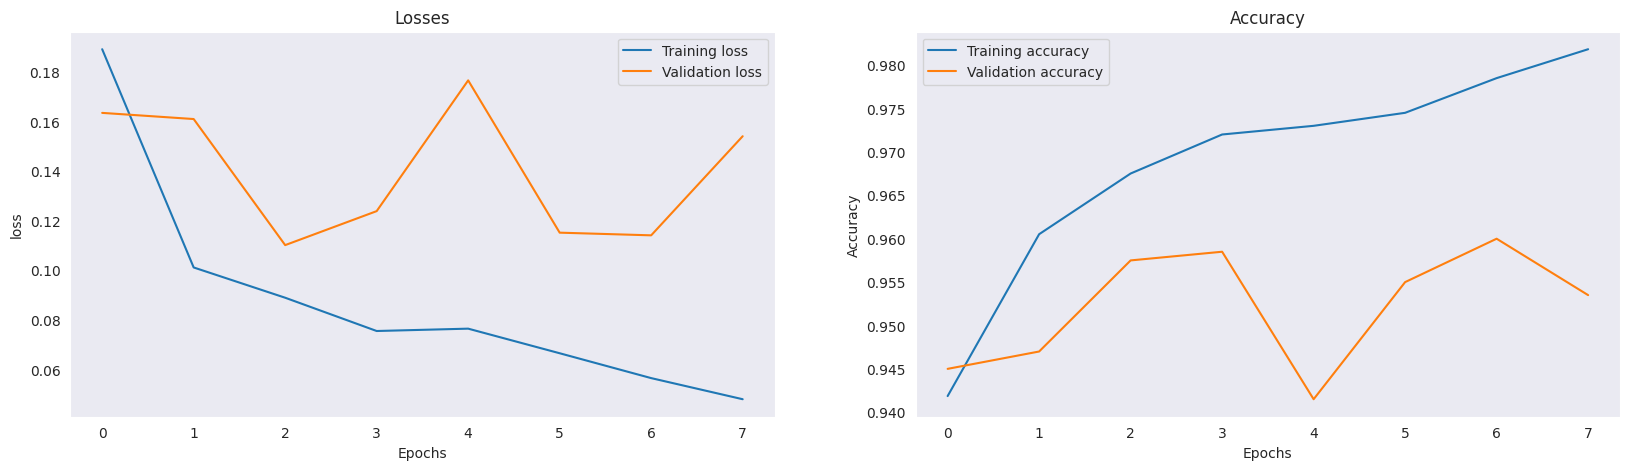

In [13]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [14]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)

model1_result = pd.DataFrame(zip(train_result, val_result),
                             columns=['Train', 'Validation'],
                             index=['Loss', "Accuracy"])

model1_result

188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9939 - loss: 0.0150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9617 - loss: 0.0927


,Train,Validation
Loss,0.013168,0.11017
Accuracy,0.995336,0.95750


In [15]:
y_pred = model1.predict(val_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = val_ds[0][-1]


print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score: ", accuracy_score(y_test,y_pred))
print("\nClassification report:\n", classification_report(y_pred,y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Confusion matrix:
 [[11  0]
 [ 0 21]]

Accuracy Score:  1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        21

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



<Axes: >

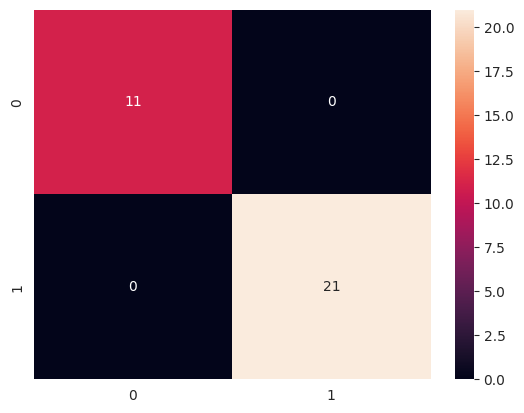

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

**Training without data augmentation**

In [17]:
from keras.applications.vgg19 import VGG19

In [18]:
tf.keras.backend.clear_session()

height=224
width=224

train_ds, val_ds,test_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 6003 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [19]:
model2.compile(loss="binary_crossentropy",
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.keras',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds,
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7786 - loss: 1.6560
Epoch 1: accuracy improved from -inf to 0.85474, saving model to model/vgg19_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 386ms/step - accuracy: 0.7790 - loss: 1.6516 - val_accuracy: 0.8735 - val_loss: 0.6632
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9349 - loss: 0.2572
Epoch 2: accuracy improved from 0.85474 to 0.92820, saving model to model/vgg19_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 293ms/step - accuracy: 0.9349 - loss: 0.2576 - val_accuracy: 0.6990 - val_loss: 2.8697
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9465 - loss: 0.2034
Epoch 3: accuracy improved from 0.92820 to 0.95219, saving model to model/vgg19_best.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 291ms/step - accuracy: 0.9465 - loss: 0.2033 - val_accuracy: 0.8660 - val_loss: 1.0736
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9784 - loss: 0.0742
Epoch 4: accuracy 

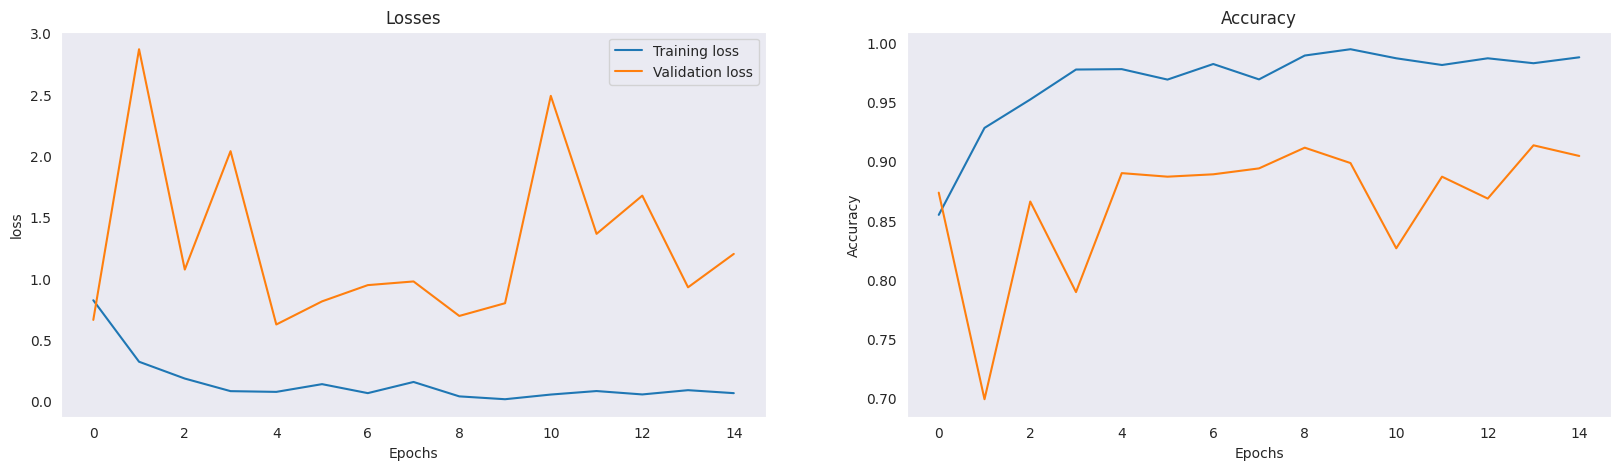

In [20]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the input image size
IMG_SIZE = 224  # Change this to the correct size you're using

# Model Definition
model2 = Sequential()

# First Conv Block
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))
model2.add(Dropout(0.25))

# Second Conv Block
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))
model2.add(Dropout(0.25))

# Third Conv Block
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2, 2))
model2.add(Dropout(0.25))

# Global Average Pooling Layer (instead of Flatten)
model2.add(GlobalAveragePooling2D())  # Reduces each feature map to a single value

# Fully Connected Layers
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))  # Dropout for regularization

# Output Layer
model2.add(Dense(1, activation='sigmoid'))  # For binary classification

# Adam Optimizer with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Training with data augmentation
history = model2.fit(
    aug_train_ds,  # Augmented training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=30,  # Number of epochs
    batch_size=32,  # Adjust batch size if necessary
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint, early, reduce_lr]
)


Epoch 1/30
 58/188 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - accuracy: 0.6708 - loss: 0.6122

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7083 - loss: 0.5677
Epoch 1: val_accuracy improved from -inf to 0.50650, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 107s 511ms/step - accuracy: 0.7085 - loss: 0.5675 - val_accuracy: 0.5065 - val_loss: 0.7122 - learning_rate: 0.0010
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7884 - loss: 0.4643
Epoch 2: val_accuracy did not improve from 0.50650
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 468ms/step - accuracy: 0.7885 - loss: 0.4642 - val_accuracy: 0.5000 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 3/30
  7/188 ━━━━━━━━━━━━━━━━━━━━ 1:32 509ms/step - accuracy: 0.8231 - loss: 0.4234

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8230 - loss: 0.4090
Epoch 3: val_accuracy did not improve from 0.50650
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 468ms/step - accuracy: 0.8231 - loss: 0.4089 - val_accuracy: 0.5010 - val_loss: 1.4453 - learning_rate: 0.0010
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8408 - loss: 0.3622
Epoch 4: val_accuracy improved from 0.50650 to 0.66750, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 481ms/step - accuracy: 0.8408 - loss: 0.3622 - val_accuracy: 0.6675 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 5/30
 22/188 ━━━━━━━━━━━━━━━━━━━━ 1:09 417ms/step - accuracy: 0.8486 - loss: 0.3189

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8586 - loss: 0.3268
Epoch 5: val_accuracy improved from 0.66750 to 0.76300, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 466ms/step - accuracy: 0.8587 - loss: 0.3268 - val_accuracy: 0.7630 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8685 - loss: 0.3114
Epoch 6: val_accuracy improved from 0.76300 to 0.92650, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 470ms/step - accuracy: 0.8686 - loss: 0.3113 - val_accuracy: 0.9265 - val_loss: 0.2317 - learning_rate: 0.0010
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8847 - loss: 0.2787
Epoch 7: val_accuracy did not improve from 0.92650
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 467ms/step - accuracy: 0.8847 - loss: 0.2787 - val_accuracy: 0.8880 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9035 - loss: 0.252

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9151 - loss: 0.2148
Epoch 10: val_accuracy improved from 0.92650 to 0.93300, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 462ms/step - accuracy: 0.9151 - loss: 0.2148 - val_accuracy: 0.9330 - val_loss: 0.1818 - learning_rate: 3.0000e-04
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9186 - loss: 0.2180
Epoch 11: val_accuracy did not improve from 0.93300
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 460ms/step - accuracy: 0.9186 - loss: 0.2180 - val_accuracy: 0.9310 - val_loss: 0.1880 - learning_rate: 3.0000e-04
Epoch 12/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9250 - loss: 0.1926
Epoch 12: val_accuracy did not improve from 0.93300
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 467ms/step - accuracy: 0.9250 - loss: 0.1927 - val_accuracy: 0.9230 - val_loss: 0.1964 - learning_rate: 3.0000e-04
Epoch 13/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9309 - loss: 0.1783
Epoch 13: val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9409 - loss: 0.1614
Epoch 15: val_accuracy improved from 0.93300 to 0.93550, saving model to best_model.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 477ms/step - accuracy: 0.9409 - loss: 0.1615 - val_accuracy: 0.9355 - val_loss: 0.1753 - learning_rate: 9.0000e-05
Epoch 16/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9337 - loss: 0.1693
Epoch 16: val_accuracy did not improve from 0.93550
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 459ms/step - accuracy: 0.9337 - loss: 0.1694 - val_accuracy: 0.9315 - val_loss: 0.1927 - learning_rate: 9.0000e-05
Epoch 17/30
 45/188 ━━━━━━━━━━━━━━━━━━━━ 1:01 428ms/step - accuracy: 0.9240 - loss: 0.1812

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9307 - loss: 0.1703
Epoch 17: val_accuracy did not improve from 0.93550
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 464ms/step - accuracy: 0.9307 - loss: 0.1703 - val_accuracy: 0.9350 - val_loss: 0.1742 - learning_rate: 9.0000e-05
Epoch 18/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9347 - loss: 0.1699
Epoch 18: val_accuracy did not improve from 0.93550
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 460ms/step - accuracy: 0.9347 - loss: 0.1699 - val_accuracy: 0.9245 - val_loss: 0.1884 - learning_rate: 9.0000e-05
Epoch 19/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9430 - loss: 0.1577
Epoch 19: val_accuracy did not improve from 0.93550
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 460ms/step - accuracy: 0.9430 - loss: 0.1577 - val_accuracy: 0.9230 - val_loss: 0.1998 - learning_rate: 9.0000e-05
Epoch 20/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9343 - loss: 0.1625
Epoch 20: val_accuracy did not improve from 0.93550

Epo

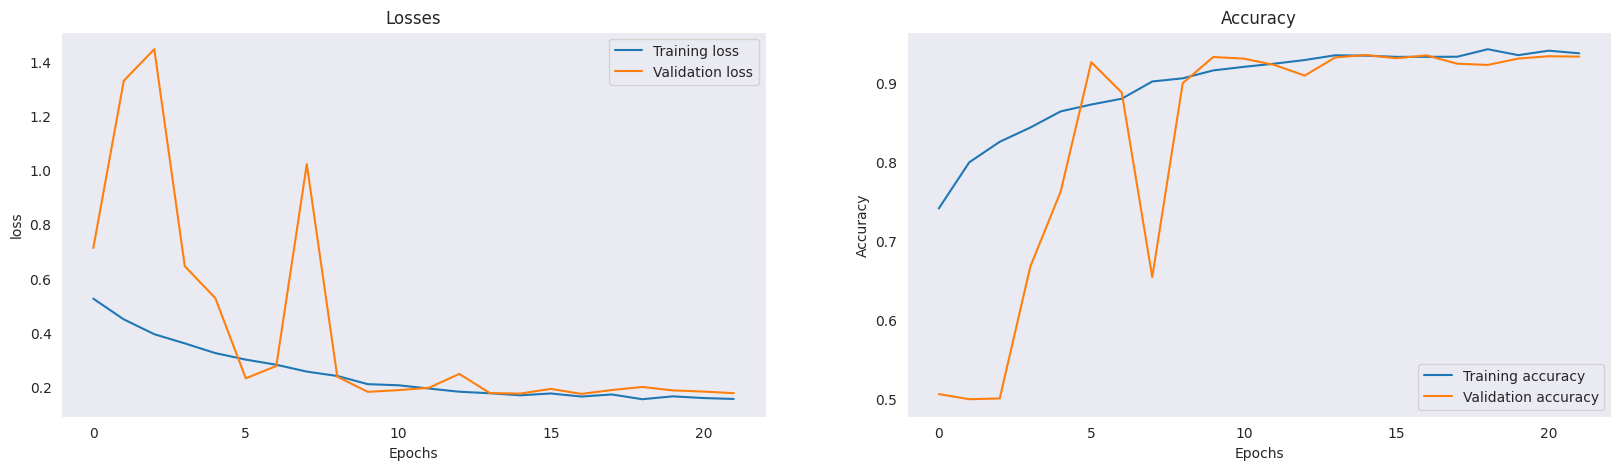

In [22]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [23]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)

model2_result = pd.DataFrame(zip(train_result, val_result),
                             columns=['Train', 'Validation'],
                             index=['Loss', "Accuracy"])

model2_result

188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9424 - loss: 0.1531
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9381 - loss: 0.1738


,Train,Validation
Loss,0.152436,0.174227
Accuracy,0.943861,0.935000


In [24]:
y_pred = model2.predict(val_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = val_ds[0][-1]


print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score: ", accuracy_score(y_test,y_pred))
print("\nClassification report:\n", classification_report(y_pred,y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step

Confusion matrix:
 [[18  1]
 [ 0 13]]

Accuracy Score:  0.96875

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.93      0.96        14

    accuracy                           0.97        32
   macro avg       0.97      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



<Axes: >

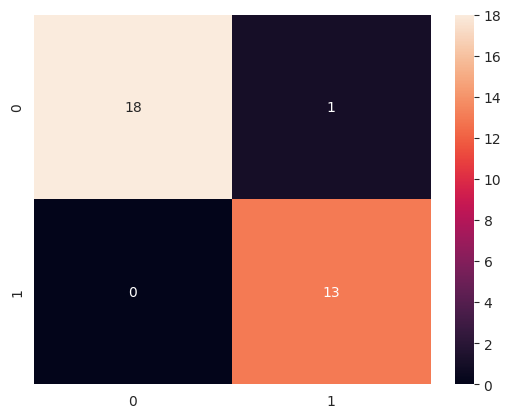

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

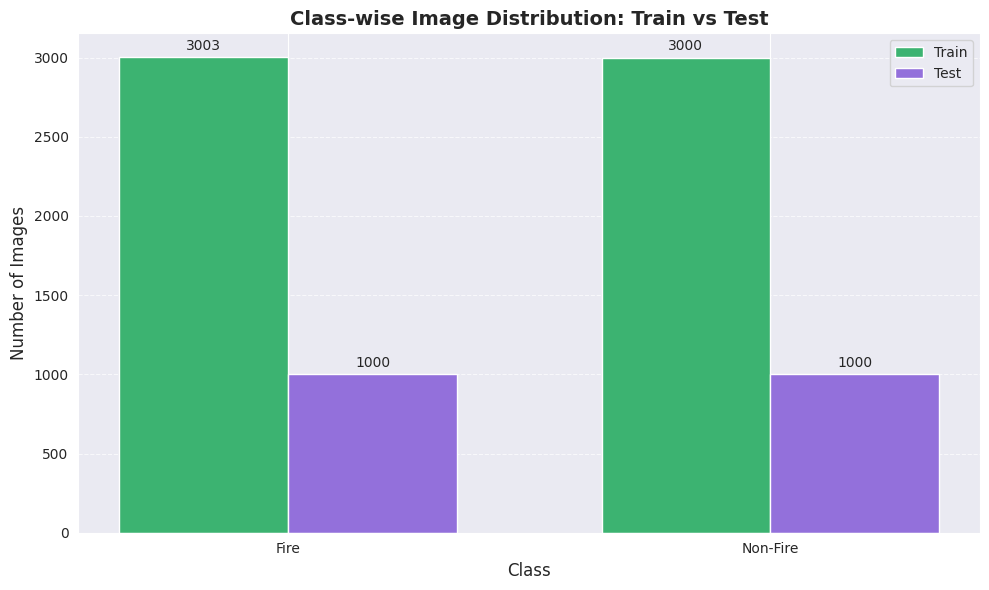

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the base path to your dataset
base_path = "/kaggle/input/urecamain"

# Categories and dataset types
categories = ['Fire', 'Non-Fire']
dataset_types = ['Train', 'Test']

# Initialize a dictionary to store counts
data_counts = {category: [] for category in categories}

# Count images per class per dataset type
for category in categories:
    for dataset_type in dataset_types:
        folder_path = os.path.join(base_path, dataset_type, category)
        image_count = len(os.listdir(folder_path))
        data_counts[category].append(image_count)

# Bar plot: Grouped by class
x = np.arange(len(categories))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
train_counts = [data_counts[cat][0] for cat in categories]
test_counts = [data_counts[cat][1] for cat in categories]

bars1 = ax.bar(x - width/2, train_counts, width, label='Train', color='mediumseagreen')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', color='mediumpurple')

# Labels and Title
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Class-wise Image Distribution: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


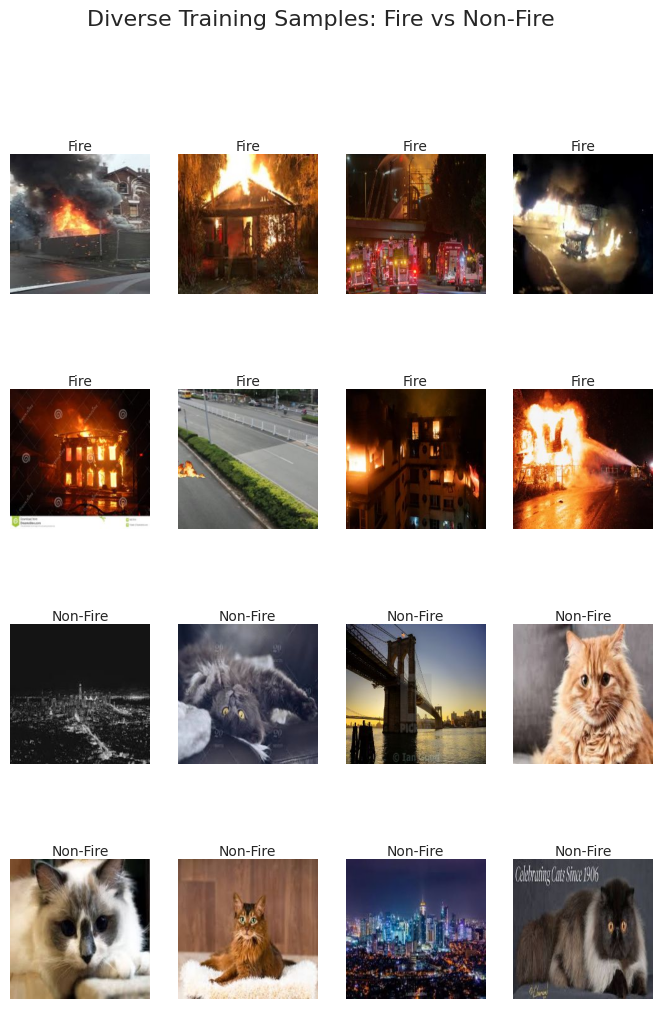

In [27]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset path and configuration
base_path = "/kaggle/input/urecamain/Train"
categories = ['Fire', 'Non-Fire']
samples_per_category = 8
# Total samples = 16; grid: 4 rows × 4 columns
total_samples = samples_per_category * len(categories)
rows, cols = 4, 4

fig, axs = plt.subplots(rows, cols, figsize=(8.3, 11.7))

# Get image paths
all_samples = []
for category in categories:
    folder = os.path.join(base_path, category)
    imgs = random.sample(os.listdir(folder), samples_per_category)
    all_samples.extend([(os.path.join(folder, img), category) for img in imgs])

# Plot the images in a grid
for ax, (img_path, label) in zip(axs.flat, all_samples):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(label, fontsize=10, verticalalignment='bottom', pad=1)

# Add a title for the grid and adjust spacing
plt.suptitle("Diverse Training Samples: Fire vs Non-Fire", fontsize=16)

plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Save as high-res image (300 DPI, ideal for Word)
plt.savefig("a4_training_samples_grid_portrait_large_images.png", dpi=300)
plt.show()
